In [1]:
# Loading up the libraries

import numpy as np
import os
import pandas as pd
import datetime
import xarray as xr
import tensorflow as tf
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
os.chdir("C:\\Users\\Greg\\code\\space-physics-machine-learning\\data")
ss = pd.read_csv("substorms_2000_2018.csv")
ss.index = pd.to_datetime(ss.Date_UTC)

Text(0, 0.5, 'probability of substorm')

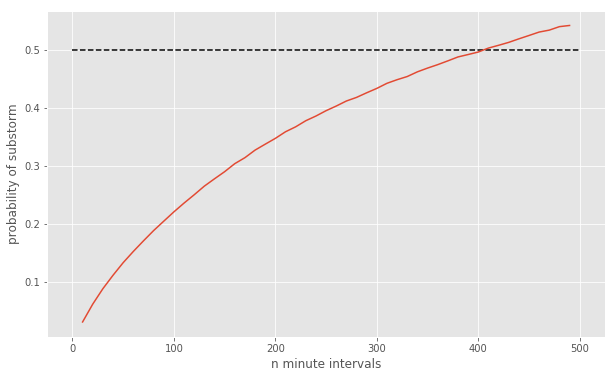

In [2]:
# This shows how the probability of a substorm being in an interval relates to the length of the interval

dt = np.round((ss.index - ss.index[0]).total_seconds()) / 60
probs = []
maxmins = 500
for m in range(10, maxmins, 10):
    hours = np.unique(np.floor(dt / m)).astype(int)
    probs.append([m, np.mean(np.in1d(np.arange(hours.max()), hours))])

probs = np.array(probs)

plt.figure(figsize=(10,6))
plt.plot(probs[:,0], probs[:,1])
plt.hlines(.5, 0, maxmins, 'k', 'dashed')
plt.xlabel('n minute intervals')
plt.ylabel('probability of substorm')

In [3]:
# loading up a magnetometer data file

mag_file = "mag_data_2000.nc"
mag_data = xr.open_dataset(mag_file)
stations_to_drop = [station for station in mag_data if np.any(np.all(np.isnan(mag_data[station]), axis=0))]
mag_data = mag_data.drop(stations_to_drop)

Text(0.5, 0, 'best n stations')

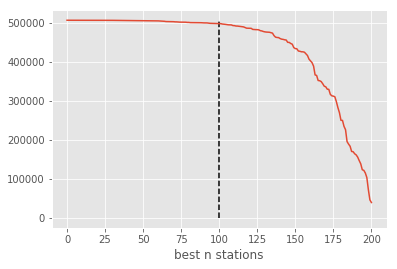

In [4]:
# how many stations might we want to use?

X = np.isfinite(mag_data.sel(dim_1='N').to_array()).sum(dim='Date_UTC')
sort_ind = np.argsort(X)[::-1]

n_stations = 100
best_stations = [station for i,station in enumerate(mag_data) if i in sort_ind[:n_stations]]

plt.plot(X[sort_ind.values])
plt.vlines(n_stations, 0, X.max(), 'k', 'dashed')
plt.xlabel('best n stations')

In [5]:
# boil dataset down to values that we want to use
data = mag_data[best_stations].sel(dim_1=['N','E','Z']).copy().to_array()
data = data.rename({'dim_1': 'component', 'Date_UTC': 'time', 'variable': 'station'})
data -= data.mean(dim='time')
data /= data.std(dim='time')
data = data.transpose('time', 'station', 'component')
data

<xarray.DataArray (time: 507007, station: 100, component: 3)>
array([[[ 0.151622,  0.162734, -0.488146],
        [-2.552113,  1.679939,  0.139178],
        ...,
        [-0.886546,  5.563051, -1.699873],
        [ 0.195263,  0.936903, -2.350923]],

       [[ 0.151622,  0.028328, -0.652933],
        [-2.499382,  2.096658,  0.023457],
        ...,
        [-0.713063,  5.432391, -1.633068],
        [ 0.143231,  0.846824, -2.274797]],

       ...,

       [[ 0.750156, -0.294246, -0.043219],
        [ 0.149822, -0.234142, -0.098784],
        ...,
        [ 0.557703, -0.264407, -0.397162],
        [ 0.225697, -0.022543, -0.209604]],

       [[ 0.750156, -0.294246, -0.043219],
        [ 0.149822, -0.234142, -0.098784],
        ...,
        [ 0.557703, -0.264407, -0.397162],
        [ 0.224715, -0.022543, -0.209604]]])
Coordinates:
  * component  (component) object 'N' 'E' 'Z'
  * time       (time) datetime64[ns] 2000-01-01T00:13:00 ... 2000-12-31T23:59:00
  * station    (station) <U3 'ABG' 'A

In [ ]:
th = 3
t0 = 100
averages = np.zeros((t0+1, 3))
n_stations = 0
plt.figure(figsize=(20,12))
for storm_index in range(100, 400):
    ss_info = ss.iloc[storm_index]
    print(ss_info.Date_UTC)
    date = datetime.datetime.strptime((ss_info.Date_UTC), '%Y-%m-%d %H:%M:%S')
    storm_data = mag_data.sel(Date_UTC=slice(date-datetime.timedelta(minutes=t0), date))
    cond = ((np.abs(storm_data.sel(dim_1='MLT') - ss_info.MLT) < th) * 
            (np.abs(storm_data.sel(dim_1='MLAT') - ss_info.MLAT) < th)).mean(dim='Date_UTC') > .5
    close_stations = [st for st in cond if cond[st]]
    try:
        storm_data = storm_data[close_stations].to_array().values
        averages += np.sum(storm_data[:,:,-3:], axis=0)
        n_stations += storm_data.shape[0]
    except:
        pass
    
averages /= n_stations
plt.plot(averages)
plt.show()

2000-01-08 14:53:00
2000-01-08 15:49:00
2000-01-09 02:35:00
2000-01-09 21:33:00
2000-01-10 18:01:00
2000-01-10 21:09:00
2000-01-10 21:31:00
2000-01-11 02:20:00
2000-01-11 15:09:00
2000-01-11 16:35:00
2000-01-11 18:13:00
2000-01-11 18:33:00
2000-01-11 18:59:00
2000-01-11 20:07:00
2000-01-11 20:34:00
2000-01-11 21:22:00
2000-01-12 01:21:00
2000-01-12 01:45:00
2000-01-12 06:16:00
2000-01-12 18:32:00
2000-01-13 01:20:00
2000-01-13 05:48:00
2000-01-13 08:22:00
2000-01-13 08:44:00
2000-01-13 12:21:00
